In [17]:
import pandas as pd
from matchms.importing import load_from_mgf
from matchms.exporting import save_as_mgf
from datetime import datetime
import os
from collections import Counter


from massspecgym.data.transforms import MolFingerprinter
from massspecgym.data.datasets import MSnDataset

from massspecgym.tools.analyzers import compute_fold_statistics
from massspecgym.tools.plots import evaluate_split
from massspecgym.tools.data import compute_murcko_histograms, group_by_murcko_histograms, split_by_murcko_histograms

## Muracko algo

In [18]:
mol_transform = MolFingerprinter(fp_size=2048)
msn_dataset = MSnDataset(pth="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf",
                         mol_transform=mol_transform,
                         max_allowed_deviation=0.005)
print(len(msn_dataset))

16476


In [3]:
df = msn_dataset.metadata 

# Compute Murcko histograms
df_us = compute_murcko_histograms(df)

# Group by Murcko histograms
df_gb = group_by_murcko_histograms(df_us)

Computing Murcko histograms...


  0%|          | 0/13996 [00:00<?, ?it/s]

In [4]:
# Split into training, validation, and test sets
smiles_to_fold = split_by_murcko_histograms(
    df_us,
    df_gb,
    val_fraction=0.10,      
    test_fraction=0.10,
    k=3,
    d=4,
    seed=42       
)

In [5]:
fold_counts = Counter(smiles_to_fold.values())
print(fold_counts)

Counter({'train': 10539, 'val': 1749, 'test': 1708})


In [6]:
df['fold'] = df['smiles'].map(smiles_to_fold)

print('Distribution of spectra:')
print(df['fold'].value_counts(normalize=True))
print('Distribution of SMILES:')
print(df.drop_duplicates(subset=['smiles'])['fold'].value_counts(normalize=True))

Distribution of spectra:
fold
train    0.750667
val      0.126240
test     0.123093
Name: proportion, dtype: float64
Distribution of SMILES:
fold
train    0.753001
val      0.124964
test     0.122035
Name: proportion, dtype: float64


In [7]:
fold_stats_standard = compute_fold_statistics(msn_dataset, smiles_to_fold)

All trees have been matched to folds.
Statistics for fold 'test':
  Number of trees: 1988
  Average depth: 2.13
  Average branching factor: 4.53
  Average precursor m/z: 352.45
  Average retention time: 72.39
  Average total nodes per tree: 11.35
  Relative abundances of adducts:
    [M+H]+: 83.95% (1669 occurrences)
    [M+NH4]+: 5.53% (110 occurrences)
    [M+H-H2O]+: 4.73% (94 occurrences)
    [M+Na]+: 2.82% (56 occurrences)
    [M]+: 2.36% (47 occurrences)
    [M+H-2H2O]+: 0.55% (11 occurrences)
    [M-H2O]+: 0.05% (1 occurrences)

Statistics for fold 'train':
  Number of trees: 12536
  Average depth: 2.12
  Average branching factor: 4.32
  Average precursor m/z: 433.05
  Average retention time: 75.82
  Average total nodes per tree: 10.97
  Relative abundances of adducts:
    [M+H]+: 82.17% (10301 occurrences)
    [M+NH4]+: 8.06% (1011 occurrences)
    [M+H-H2O]+: 4.07% (510 occurrences)
    [M+Na]+: 2.43% (304 occurrences)
    [M]+: 2.21% (277 occurrences)
    [M+H-2H2O]+: 0.94% (

Computing Morgan fingerprints for training set...
Computing Morgan fingerprints for validation set...
Computing maximum Tanimoto similarities for validation set...
Plotting histogram of maximum Tanimoto similarities...


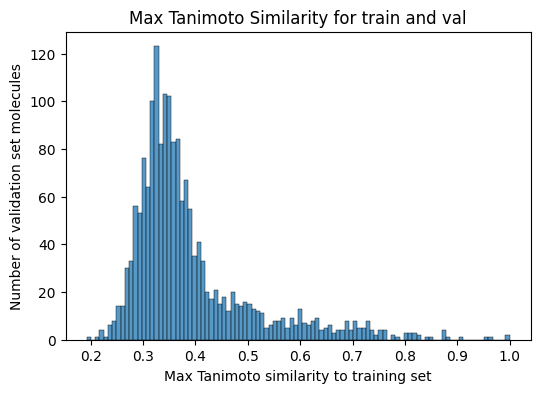

In [8]:
max_tanimoto_similarities = evaluate_split(
    df_split=df,
    train_fold='train',
    val_fold='val',
    smiles_col='smiles',
    radius=2,
    n_bits=2048
)

Computing Morgan fingerprints for training set...
Computing Morgan fingerprints for validation set...
Computing maximum Tanimoto similarities for validation set...
Plotting histogram of maximum Tanimoto similarities...


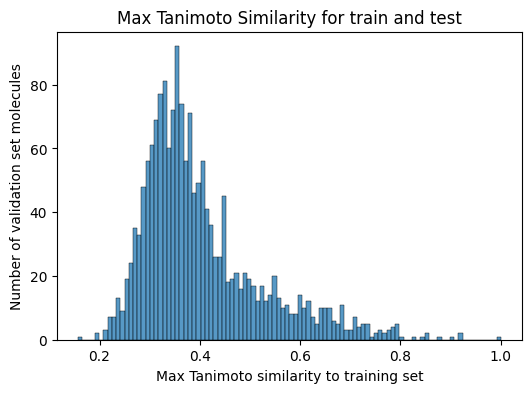

In [9]:
max_tanimoto_similarities = evaluate_split(
    df_split=df,
    train_fold='train',
    val_fold='test',
    smiles_col='smiles',
    radius=2,
    n_bits=2048
)

Computing Morgan fingerprints for training set...
Computing Morgan fingerprints for validation set...
Computing maximum Tanimoto similarities for validation set...
Plotting histogram of maximum Tanimoto similarities...


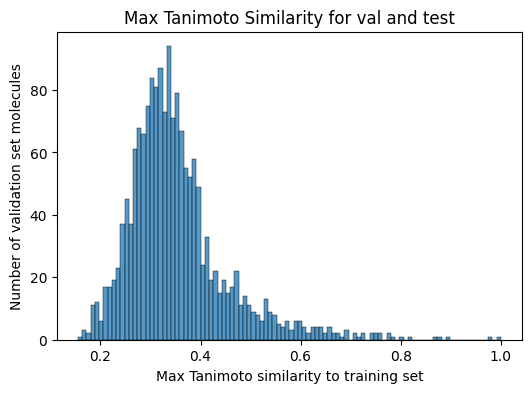

In [10]:
max_tanimoto_similarities = evaluate_split(
    df_split=df,
    train_fold='val',
    val_fold='test',
    smiles_col='smiles',
    radius=2,
    n_bits=2048
)

## Saving Results

In [11]:
SPECTRA_PATH = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
SAVE_PATH = "../../../data/MSn"

In [12]:
all_spectra = list(load_from_mgf(SPECTRA_PATH ))

In [13]:
for spectrum in all_spectra:
    smiles = spectrum.get('smiles')
    fold = smiles_to_fold.get(smiles, 'unknown')
    spectrum.set('fold', fold)

In [14]:
current_date = datetime.now().strftime("%Y%m%d")
output_file_name = f"{current_date}_msn_library_pos_all_lib_MSn.mgf"
output_file_path = os.path.join(SAVE_PATH, output_file_name)

# if os.path.exists(output_file_path):
#     os.remove(output_file_path)
#     print(f"Old file {output_file_name} removed.")
    
# save_as_mgf(all_spectra, output_file_path)

Old file 20241211_msn_library_pos_all_lib_MSn.mgf removed.
dict_keys(['spectra'])


#### Saving tsv fold identifiers

In [15]:
identifier_to_fold = {}

for tree in msn_dataset.trees:
    root_identifier = tree.root.spectrum.get('identifier')
    smiles = tree.root.spectrum.get('smiles')
    fold = smiles_to_fold.get(smiles, 'unknown')
    identifier_to_fold[root_identifier] = fold

In [16]:
split_df = pd.DataFrame(list(identifier_to_fold.items()), columns=['identifier', 'fold'])

output_file_name = f"{current_date}_split.tsv"
output_file_path = os.path.join(SAVE_PATH, output_file_name)

# split_df.to_csv(output_file_path, sep='\t', index=False)#%%
